# FRB 180916.J0158 + 65: Arima
Adaptado de: https://github.com/aarshayj/Analytics_Vidhya/tree/master/Articles/Time_Series_Analysis

## Leyendo una serie de tiempo con Pandas

#### Para ejecutar una 'celda', posicionarse sobre ella y dar CTRL+ENTER.

Primero cargamos las librerías necesarias:

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12

Si "In [  ]" se convierte en "In [1]", es que la celda fue ejecutada sin errores. Si tenemos errores aquí, nos falta instalar alguna librería

Ahora cargamos los datos del archivo CSV:

In [2]:
data_crudos = pd.read_csv("/home/wattie/frb/conteo.csv", index_col='mjd')
data = data_crudos.dropna()

data.head() imprime las primeras filas del archivo de datos

In [3]:
print(data.head())

                      flux           err
mjd                                     
58384.656539  7.474790e-07  8.117740e-07
58385.656551  1.501550e-08  3.429200e-08
58386.656563  3.139770e-08  1.235600e-77
58387.656574  2.708430e-11  1.580550e-09
58388.656586  2.574390e-11  7.075870e-10


Y podemos consultar el tipo de datos de cada columna:

In [4]:
print(data.dtypes)

flux    float64
err     float64
dtype: object


Podemos volver a cargar los datos indicándole a Pandas que la primera columna contiene fechas en el formato AÑO-MES:

In [6]:
#data = pd.read_csv('AirPassengers.csv', parse_dates=[0], index_col='Month', date_parser=dateparse)

Ahora 'data' es un objeto "inteligente" de Pandas, llamado un DataFrame.

In [7]:
#type(data)

pandas.core.frame.DataFrame

Un DataFrame tiene un "índice" a través del cual podemos extraer valores:

In [5]:
data.index

Float64Index([ 58384.65653935409,  58385.65655092816, 58386.656562502234,
               58387.65657407631,  58388.65658565037, 58389.656597224435,
               58390.65660879851,  58391.65662037259,  58392.65663194666,
               58393.65664352074,
              ...
               58761.66090278001, 58762.660914354085, 58763.660925928154,
              58764.660937502216, 58765.660949076286, 58766.660960650355,
              58767.660972224425,  58768.66098379851,  58769.66099537258,
               58770.66100694666],
             dtype='float64', name='mjd', length=318)

Por simplicidad, extraremos la columna 'Passengers' del DataFrame para obtener solamente la serie de tiempo:

In [6]:
ts = data['flux']
ts.head(10)

mjd
58384.656539    7.474790e-07
58385.656551    1.501550e-08
58386.656563    3.139770e-08
58387.656574    2.708430e-11
58388.656586    2.574390e-11
58389.656597    9.844900e-08
58390.656609    2.770930e-11
58391.656620    4.170140e-11
58392.656632    2.600290e-07
58393.656644    3.256690e-11
Name: flux, dtype: float64

'ts' es ahora un objeto de tipo Series, el cual representa una serie de tiempo:

In [7]:
type(ts)

pandas.core.series.Series

### Accesando objetos de tipo Series

Podemos accesar los valores de la serie de tiempo usando una fecha como índice:

In [12]:
ts[58392.656632:58393.656644]

mjd
58393.656644    3.256690e-11
Name: flux, dtype: float64

Podemos también especificar un rango de fechas

In [12]:
#ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

Si se deja el inicio del rango vacío, esto quiere decir "desde el inicio hasta ..."

In [13]:
#ts[:'1949-05-01']

Podemos también dar fechas que engloban un rango. Por ejemplo, todas las filas de 1960:

# Probando la estacionariedad de la serie

### Antes que nada, ¡graficarla!

El comando plt.plot() grafica una secuencia de valores o en este caso una serie de tiempo de Pandas:

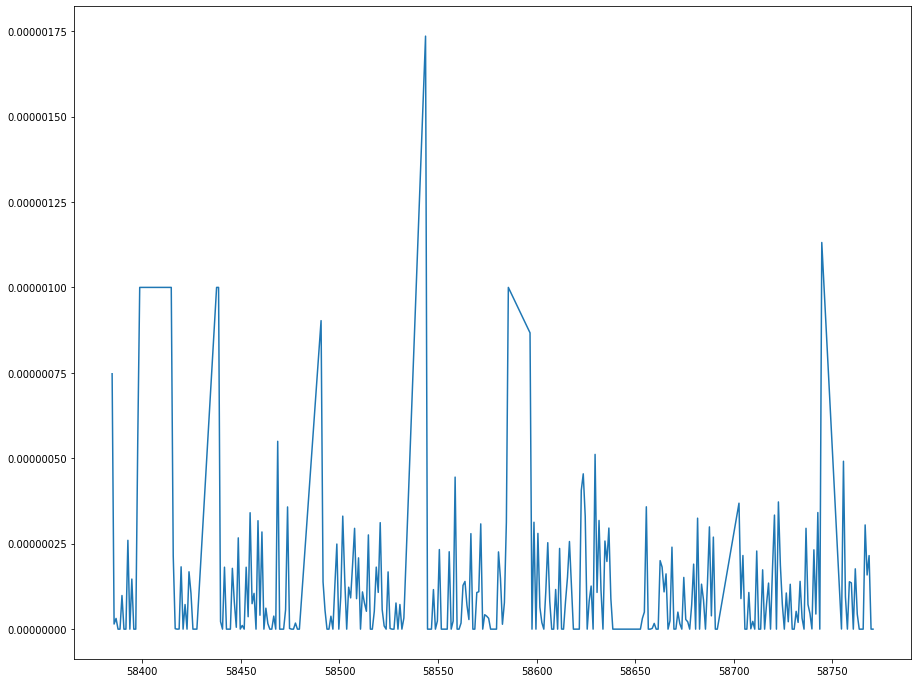

In [18]:
plt.plot(ts)

### Verificar la estacionariedad <i>a ojo</i>: media y desviación estándar

Recordar de la definición de estacionareidad requiere que la serie tenga <b>media</b> y <b>varianza</b> (o desviación estándar) <i><b>constantes</b></i>.

Podemos calcular la media de la serie de tiempo con .mean():

In [19]:
ts.mean()

1.5975515140408814e-07

Pero esto nos da la media de <i>todos</i> los valores de la serie de tiempo. ¿Cómo saber si la media está cambiando con el tiempo?

La forma más simple es calcular una <b>media móvil</b>. En cada instante del tiempo, promediamos los valores circundantes de la serie de tiempo en una ventana de tiempo limitado.

Por ejemplo, podemos calcular una media móvil promediando sobre los 30 días alrededor de cada fecha:

In [24]:
mediamovil = ts.rolling(window=30,center=True).mean()

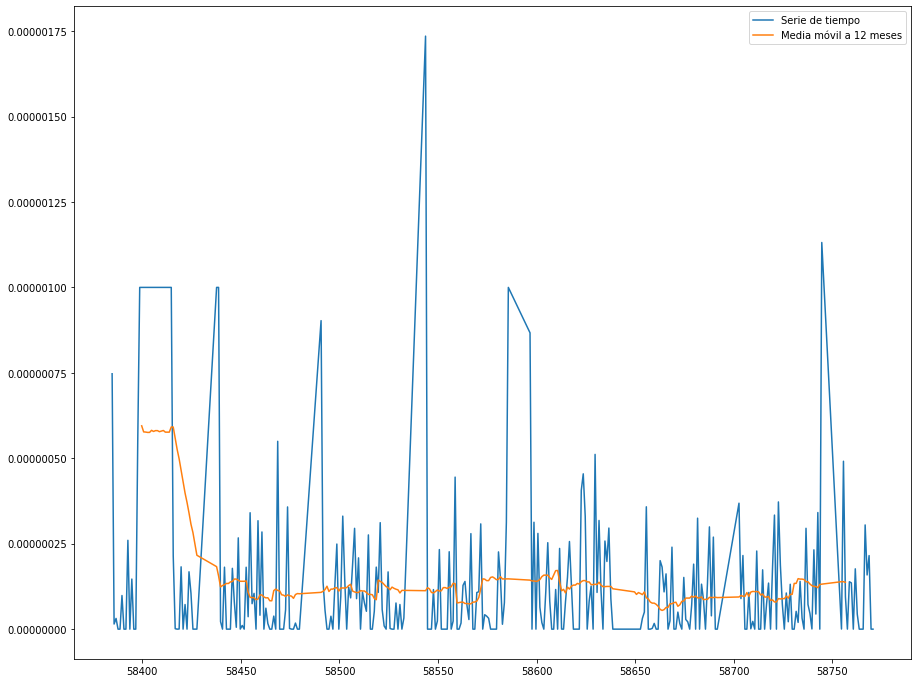

In [25]:
plt.plot(ts, label="Serie de tiempo")
plt.plot(mediamovil, label="Media móvil a 12 meses")
plt.legend(loc='best')

Vemos que la media <b>NO</b> es constante en el tiempo, por lo que la serie <b>no es estacionaria</b>.

Similarmente, podemos calcular la <b>desviación estándar móvil</b>, definida de la misma manera:

In [26]:
desvmovil = ts.rolling(window=30,center=True).std()

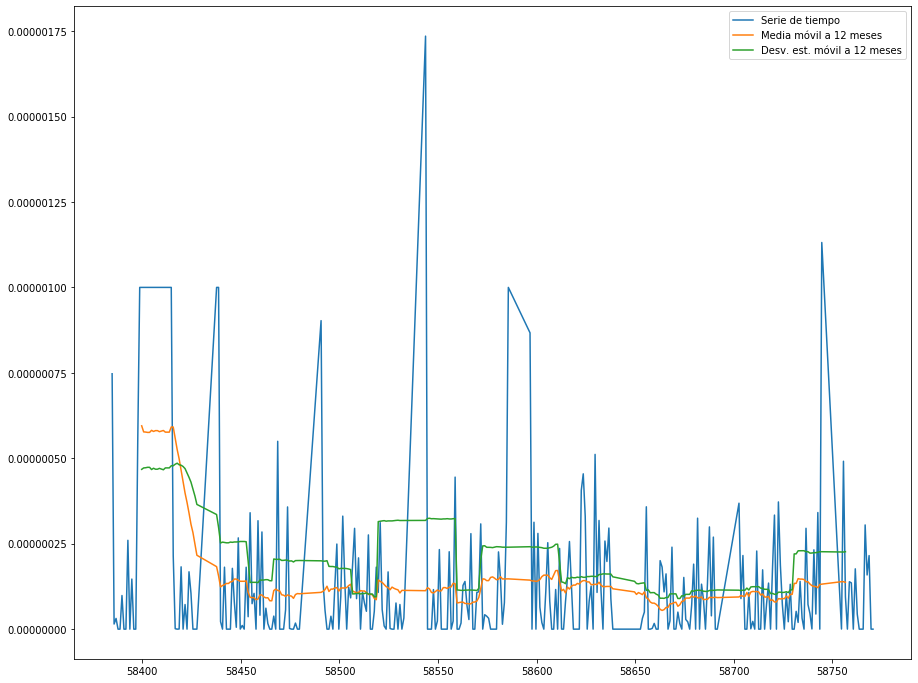

In [27]:
plt.plot(ts, label="Serie de tiempo")
plt.plot(mediamovil, label="Media móvil a 12 meses")
plt.plot(desvmovil, label="Desv. est. móvil a 12 meses")
plt.legend(loc='best')

La desviación estándar está mucho más cerca de ser constante, lo cual nos dice que la variabilidad de la serie no cambia mucho con el tiempo. Pero como la media sí, la serie no es estacionaria.

### Probando la estacionariedad de forma estadística: la prueba de Dickey-Fuller

La librería statsmodels contiene contiene la prueba estadística Dickey-Fuller de estacionariedad.
Definamos la siguiente función hacemos para hacer la prueba e imprimir los resultados automáticamente:

In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determinar estadísticas móviles
    rolmean = timeseries.rolling(window=12,center=True).mean()
    rolstd = timeseries.rolling(window=12,center=True).std()

    # Graficar estadísticas móviles
    orig = plt.plot(timeseries, color='blue',label='Serie de tiempo')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desv. est. móvil')
    plt.legend(loc='best')
    plt.title('Serie de tiempo con media y desv. est. móviles')
    plt.show(block=False)
    
    # Realizar prueba Dicket-Fuller
    dftest = adfuller(timeseries, autolag='AIC')
    tstat = dftest[0]; pvalue = dftest[1]; cvalues = dftest[4]
    print('Resultado de la prueba Dickey-Fuller')
    print("------------------")
    print("Estadística de prueba\t",tstat)
    print("p-value\t\t\t",pvalue)
    print("------------------")
    print("Valores críticos (la estadística de prueba debe ser MENOR)")
    for clevel in [10,5,1]:
        conf = 100-clevel
        cval = cvalues['%i%%' % clevel]
        if tstat < cval:
            comp = ">"
            verdict = "PASA"
        else:
            comp = "<"
            verdict = "FALLA"        
        print("Confianza %i%%\t\t%f %s %f ... %s" % (conf, cval, comp, tstat, verdict))

Apliquemos la prueba a nuestra serie de tiempo:

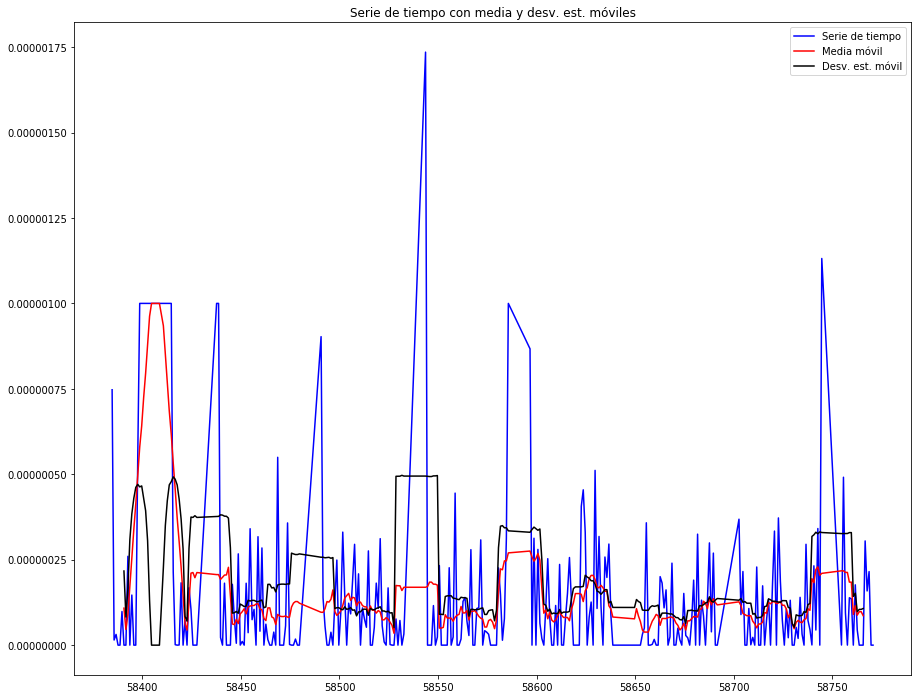

Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -4.238085369751354
p-value			 0.0005676308441483425
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.571714 > -4.238085 ... PASA
Confianza 95%		-2.870819 > -4.238085 ... PASA
Confianza 99%		-3.451416 > -4.238085 ... PASA


In [29]:
test_stationarity(ts)

Vemos que la estadística de prueba es <b>mayor</b> que todos los valores críticos, por lo que <b>no podemos rechazar</b> la hipótesis nula de no-estacionariedad. La prueba de Dickey-Fuller nos confirma lo que sospechábamos.

# Haciendo que la serie de tiempo sea estacionaria

La idea es que para modelar la serie de tiempo necesitamos primero hacerla estacionaria. Sólo entonces podremos usar alguno de los modelos de procesos estocásticos que hemos visto.

## Estimando y eliminando la tendencia


Antes de extraer la tendencia vamos a transformar la serie de tiempo para reducir la amplitud de su variabilidad. Esto es opcional, pero usualmente ayuda a la extracción de la tendencia.

Una forma común de hacer esto es tomar el <b>logaritmo</b> de la serie de tiempo:

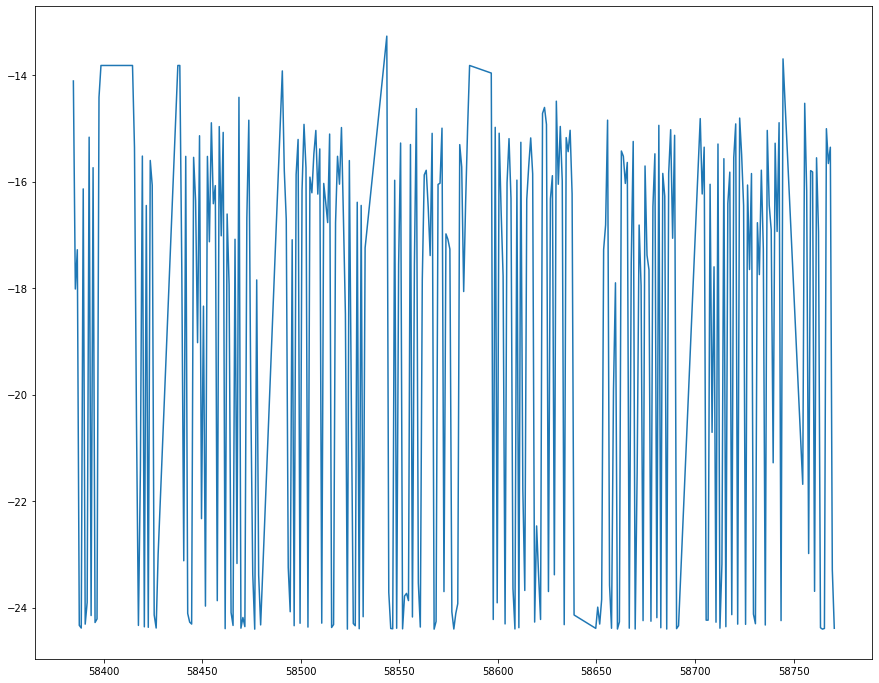

In [30]:
ts_log = np.log(ts)
plt.plot(ts_log)

Notar que mientras antes los valores de la serie estaban en los cientos, ahora son menores que 6.5.

## Suavizando para encontrar la tendencia

### Promediado móvil

La media móvil sirve no solamente para determinar la estacionariedad de la serie, sino también como una estimación simple de su tendencia.

Esta vez tomamos la media móvil con los <i>últimos</i> 12 valores (meses):

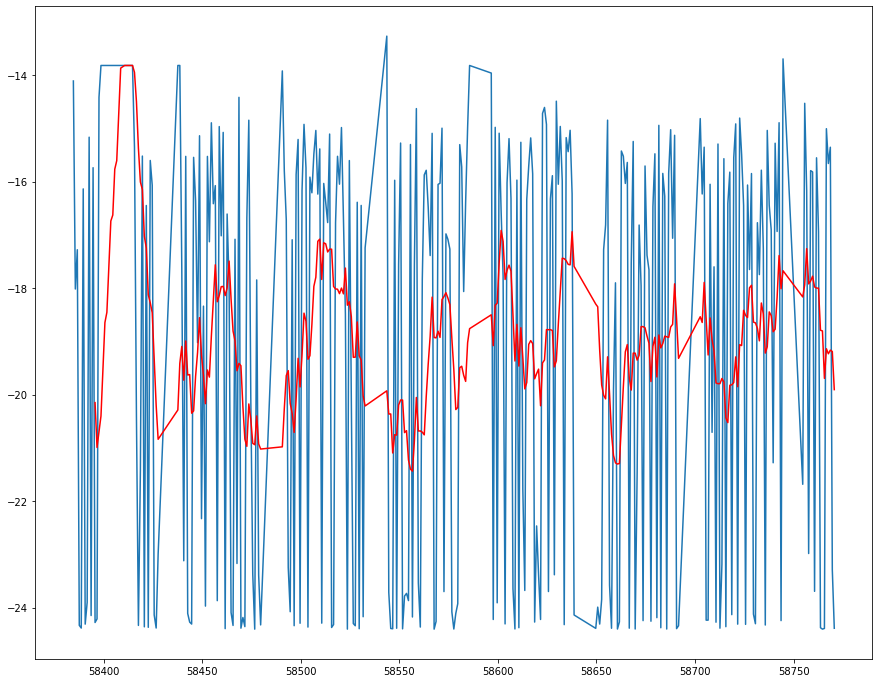

In [31]:
moving_avg = ts_log.rolling(window=12,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

Tomemos ahora la <b>diferencia</b> entre la serie y su promedio móvil:

In [32]:
ts_log_moving_avg_diff = ts_log - moving_avg

Nótese que no podemos calcular el promedio móvil para los primeros 11 valores, pues necesitamos promediar sobre 12 meses.

Esto se puede ver imprimiendo los primeros 12 valores de lo que hemos obtenido, y constatando que los primeros 11 son NaN (Not a Number):

In [34]:
ts_log_moving_avg_diff.head(30)

mjd
58384.656539             NaN
58385.656551             NaN
58386.656563             NaN
58387.656574             NaN
58388.656586             NaN
58389.656597             NaN
58390.656609             NaN
58391.656620             NaN
58392.656632             NaN
58393.656644             NaN
58394.656655             NaN
58395.656667   -4.130299e+00
58396.656678   -3.220825e+00
58397.656690    6.276978e+00
58398.656701    6.586573e+00
58399.656713    5.710175e+00
58400.656725    4.829549e+00
58401.656736    4.636346e+00
58402.656748    3.761850e+00
58403.656759    2.921418e+00
58404.656771    2.809154e+00
58405.656782    1.948118e+00
58406.656794    1.788105e+00
58407.656806    9.161612e-01
58408.656817    4.983588e-02
58410.656840   -3.552714e-15
58411.656852   -3.552714e-15
58412.656863   -3.552714e-15
58413.656875   -3.552714e-15
58414.656887   -3.552714e-15
Name: flux, dtype: float64

Para quitarlos, Pandas tiene la función dropna(), la cual elimina los NaNs:

In [35]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

mjd
58395.656667   -4.130299
58396.656678   -3.220825
58397.656690    6.276978
58398.656701    6.586573
58399.656713    5.710175
Name: flux, dtype: float64

Podemos ahora sí ver si esto ha mejorado la estacionariedad de la serie:

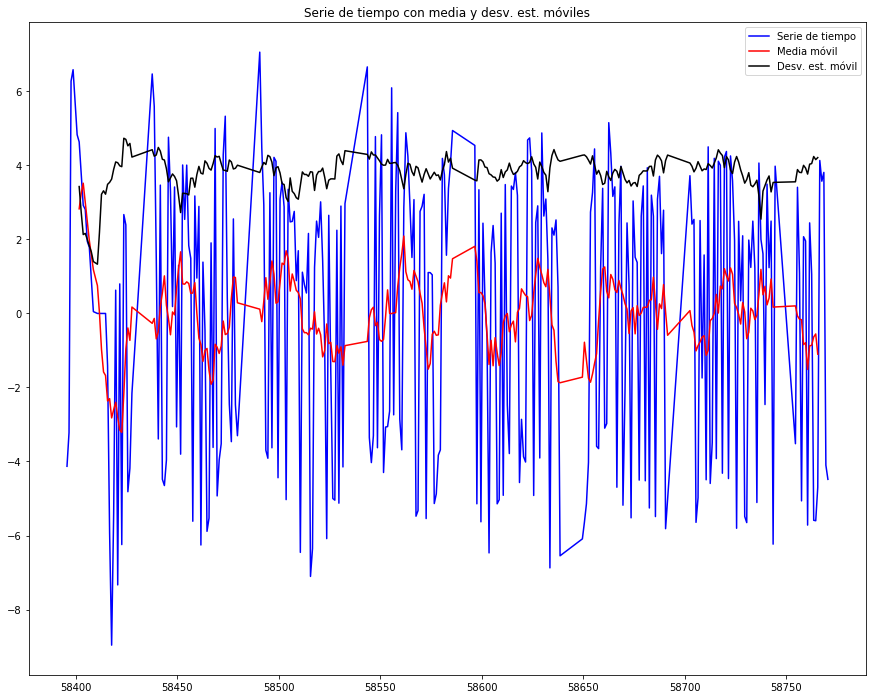

Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -10.840788209921005
p-value			 1.6179804050657222e-19
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.571861 > -10.840788 ... PASA
Confianza 95%		-2.871095 > -10.840788 ... PASA
Confianza 99%		-3.452045 > -10.840788 ... PASA


In [36]:
test_stationarity(ts_log_moving_avg_diff)

Vemos que ahora la serie <b>pasa</b> la prueba de estacionariedad a un nivel de confianza de 95%.

## Capturando la tendencia y periodicidades (i.e. "estacionalidad")

Aunque hemos capturado bien la tendencia de la serie, aún queda claro que tiene variaciones periódicas ("estacionales", como las estaciones del año ... en este caso de hecho sí son estaciones, pero el término se usa de forma genérica).

Una manera popular de capturar la tendencia en la presencia de periodicidades de mediano o largo plazo es <b>diferenciando</b> la serie, es decir, tomando la aproximación discreta de su derivada.

La forma más sencilla de hacer esto es simplemente restar la serie movida en 1:

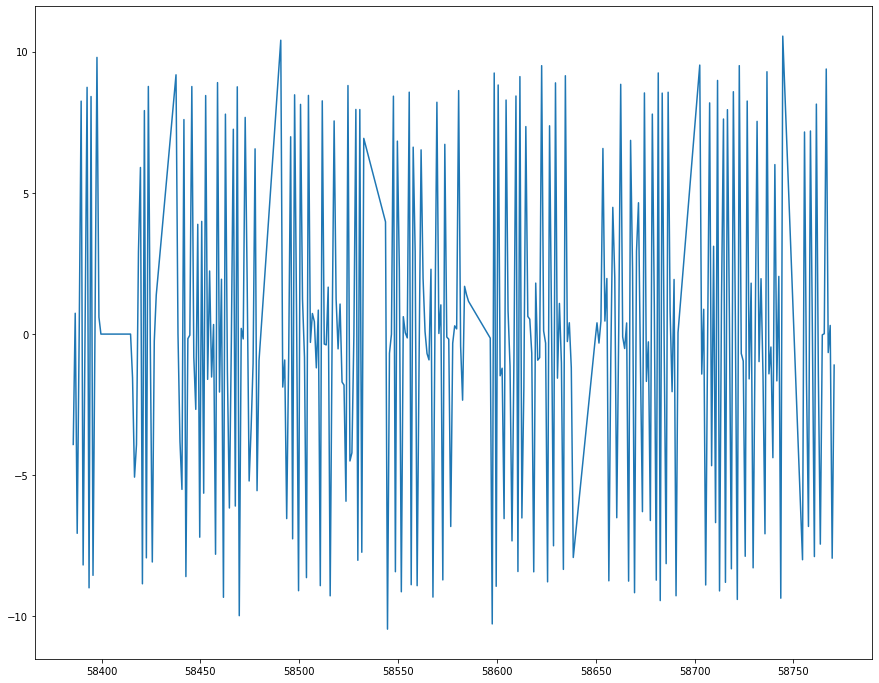

In [37]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

Descartando el primer valor (pues no tiene valor anterior), y corriendo la prueba de estacionariedad:

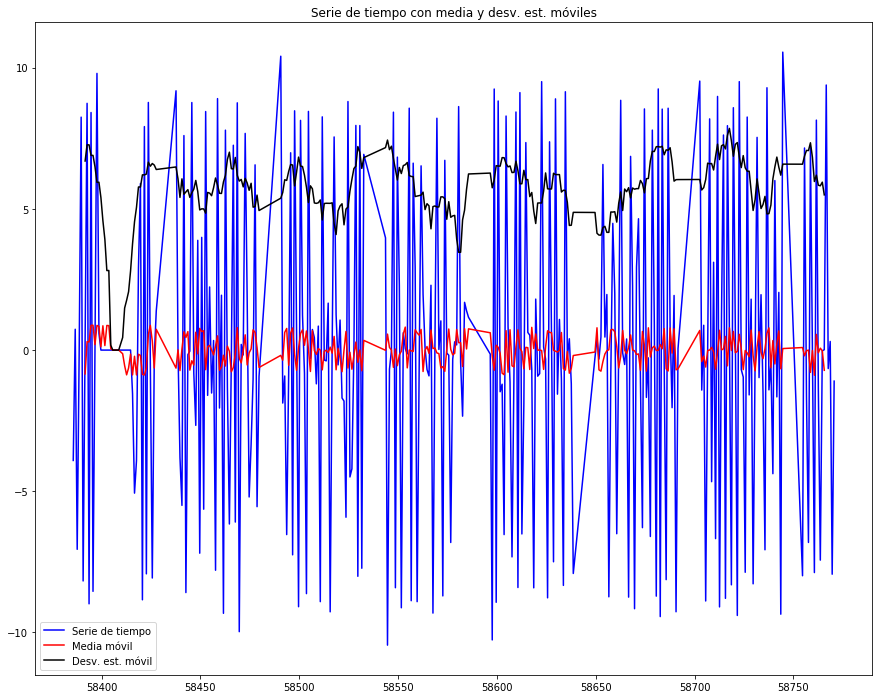

Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -11.020899709672847
p-value			 5.991451308623519e-20
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.571778 > -11.020900 ... PASA
Confianza 95%		-2.870939 > -11.020900 ... PASA
Confianza 99%		-3.451691 > -11.020900 ... PASA


In [38]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Esto pasa la prueba a 90% de confianza, aunque no es mejor que nuestro intento anterior.

### Descomposición de la serie en tendencia y estacionalidad

El siguiente paso es <b>descomponer</b> la serie identificando por separado la tendencia y la estacionalidad. Aunque eso se puede hacer de muchas formas, statsmodels incluye una herramienta para hacerlo automáticamente:

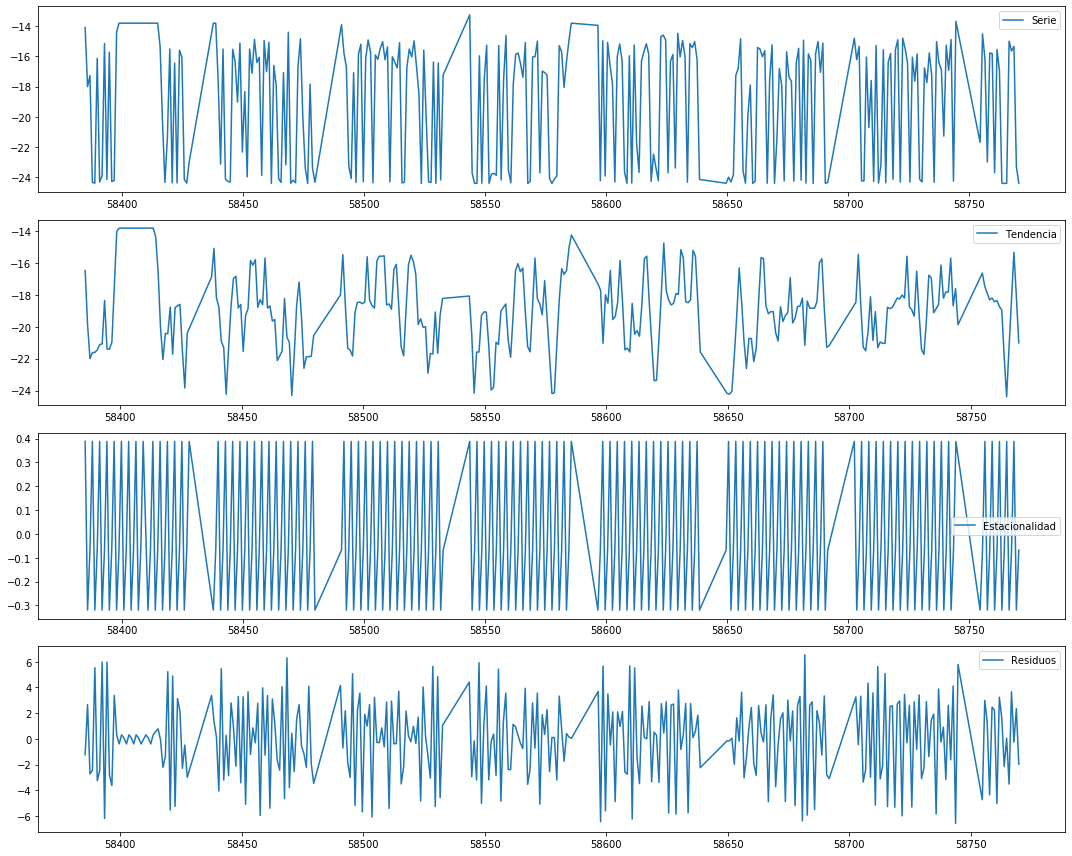

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,freq=3)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Serie')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuos')
plt.legend(loc='best')
plt.tight_layout()

Si hacemos de nuevo la prueba de estacionariedad,

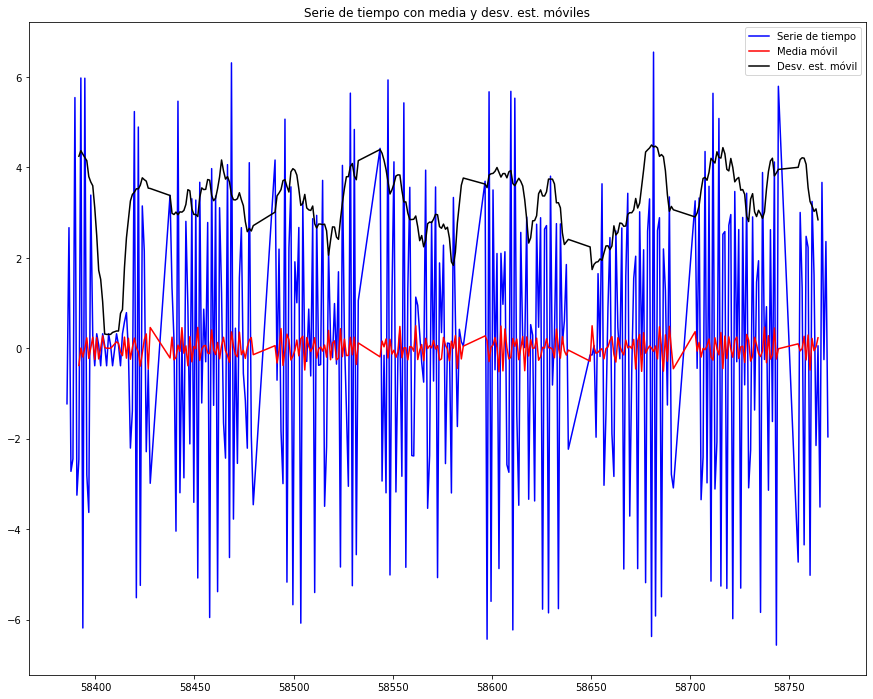

Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -9.516447351979373
p-value			 3.1478010285929246e-16
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.571929 > -9.516447 ... PASA
Confianza 95%		-2.871223 > -9.516447 ... PASA
Confianza 99%		-3.452337 > -9.516447 ... PASA


In [41]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Vemos que esto es sustancialmente mejor, con la mejor estadística de prueba hasta el momento (ojo que la escala vertical es muy pequeña: la media y desv. est. son casi constantes):

# Modelado de la serie

Habiendo forzado la serie a ser estacionaria, podemos ahora usar los modelos de procesos estocásticos para modelar su variabilidad, lo cual es lo que queda una vez sustraidas la tendencia y la estacionalidad.

Para esto usaremos el modelo general ARIMA (Auto-Regressive Integrated Moving Average) de statsmodel, el cual permite combinar los varios tipos de modelos estocásticos:

In [43]:
from statsmodels.tsa.arima_model import ARIMA

Un modelo ARIMA depende de tres parámetros:

$ARIMA(p,d,q)$

donde $p$ indica el orden de la componente autoregresiva, $d$ el orden de diferenciación y $q$ el orden de la componente de media móvil.

El valor de $d$ puede estimarse según el número de veces que se tiene que diferenciar la serie para obtener algo aproximadamente estacionario; en este caso, vimos que una diferenciación ($d=1$) bastaba.

Para estimar los valores de $p$ y $d$, calculamos las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) de la serie de tiempo. Statsmodel tiene herramientas para calcularlas.

### ACF & PACF Plots

A continuación se muestran las funciones de autocorrelación y autocorrelación parcial de la serie de tiempo (transformada y diferenciada, ya que esto da una serie casi estacionaria, como vimos).

La líneas punteadas indican los valores dentro de los cuales podemos decir que la autocorrelación es nula (comúnmente se escoge 95% de confianza, lo cual corresponde a 1.96 desviaciones estándares).

/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


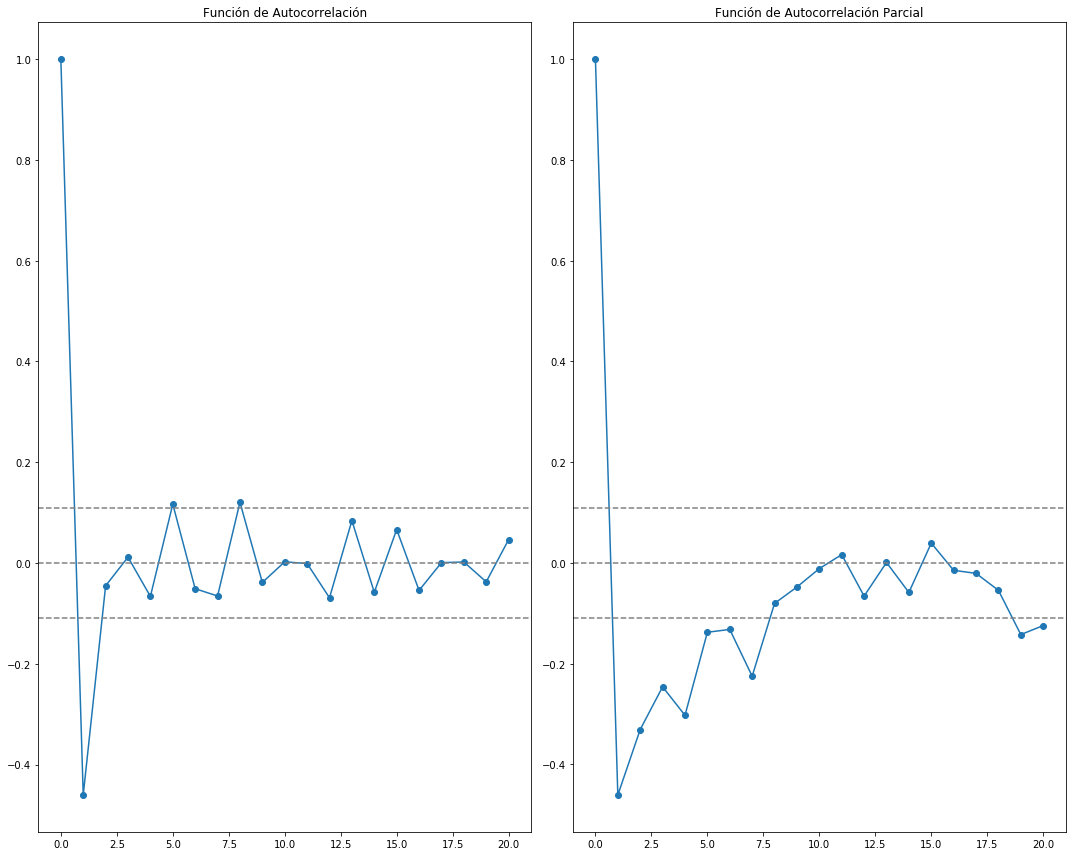

In [44]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf,"-o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf,"-o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial')
plt.tight_layout()

Usamos las gráficas para obtener los valores de $p$ y $q$ de la siguiente forma:
<ul>
<li>$q$ es el valor de retraso al cual la ACF cruza el límite de confianza superior, lo cual quiere decir que la correlación ha desaparecido. En este caso, $q=2$.</li>
<li>$p$ es el valor de retraso al cual la PACF cruza el límite de confianza superior, lo cual quiere decir que la correlación parcial ha desaparecido. En este caso, $p=2$.</li>
</ul>

Creemos ahora tres modelos diferentes: un modelo AR(2), uno MA(2) y su combinación.

### Modelo AR(p=2)

Denotaremos con RSS la suma de residuos cuadráticos entre el modelo y la serie.

/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 6954.1577')

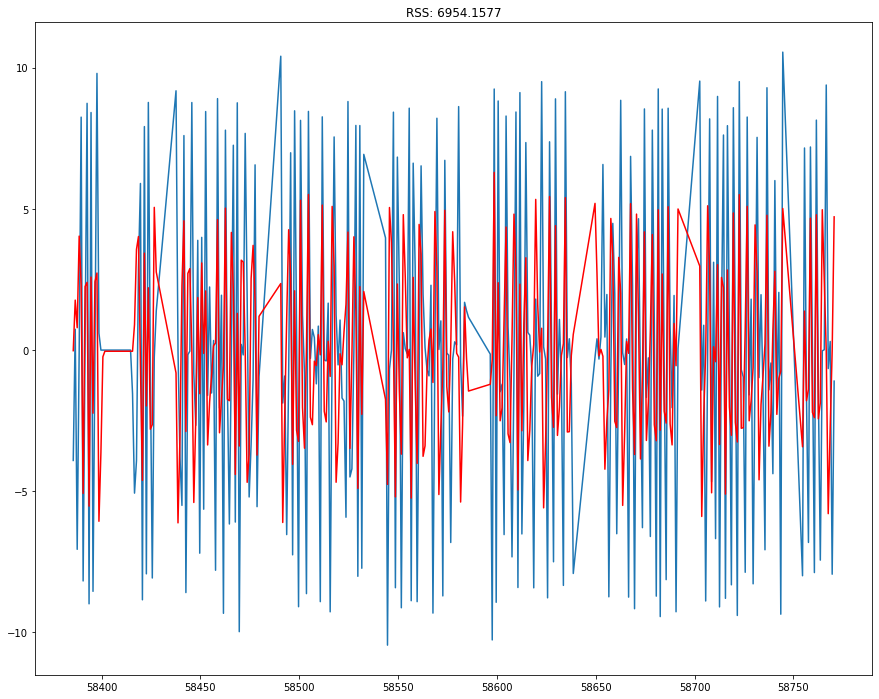

In [45]:
#MA model:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### Modelo MA(q=2)

/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 5358.1863')

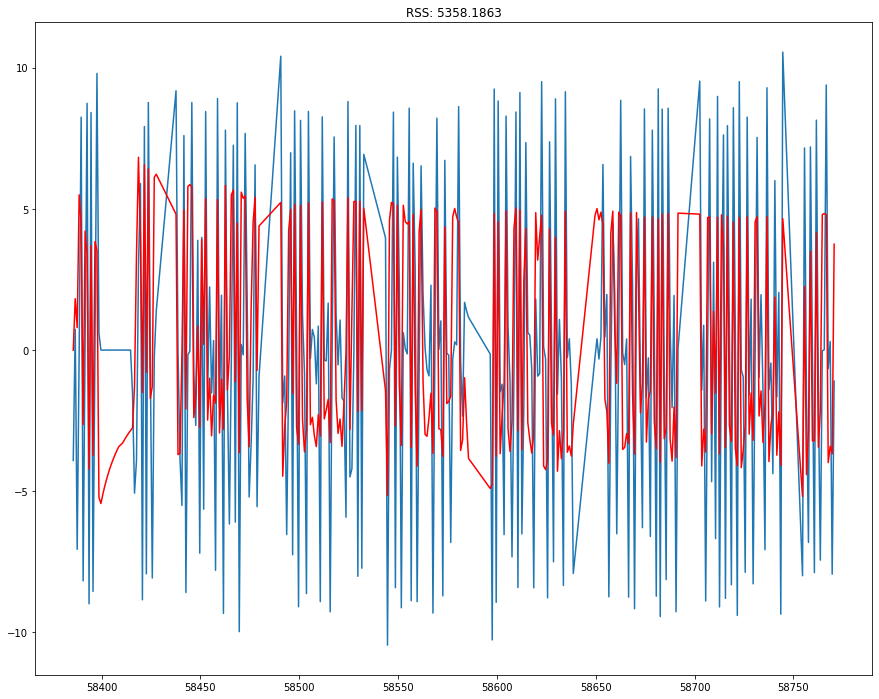

In [46]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Modelo combinado ARIMA

Finalmente, combinando los dos modelos:

/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/wattie/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RSS: 5359.0152')

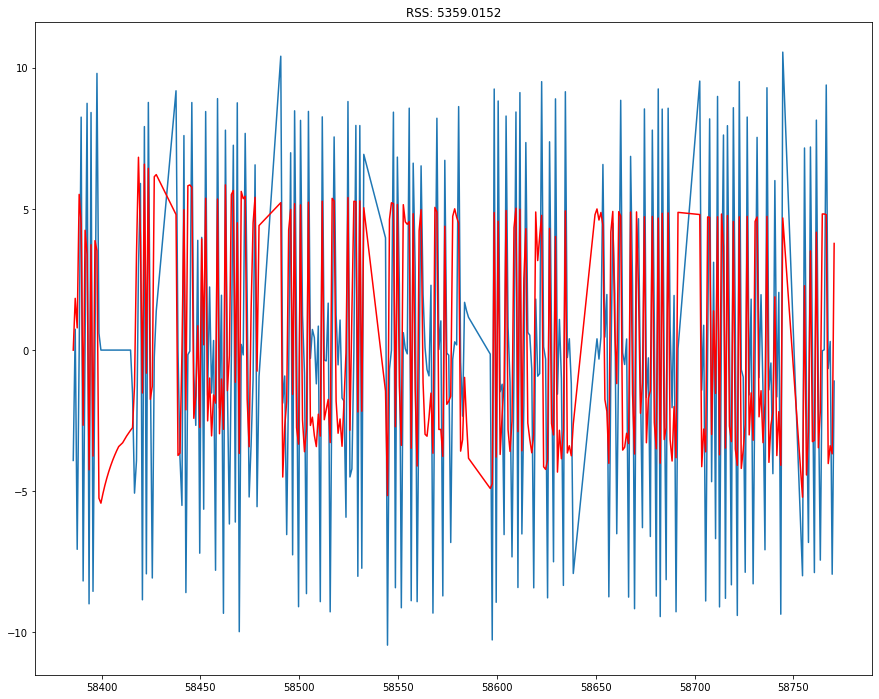

In [47]:
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Se ve que la suma de los modelos AR y MA produce algo más cercano al comportamiento estadístico de la serie.

### Revirtiendo el modelo a la escala original

Finalmente, revertimos a la escala original aplicando las transformaciones inversas-

Primero, acumulamos para revertir la diferenciación:

In [48]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

Segundo, aplicamos el logaritmo inverso, i.e. la exponencial (además, agregamos de regreso el primer valor de la serie, el cual habíamos eliminado):

Text(0.5, 1.0, 'RMSE: 8717900022662905875922944.0000')

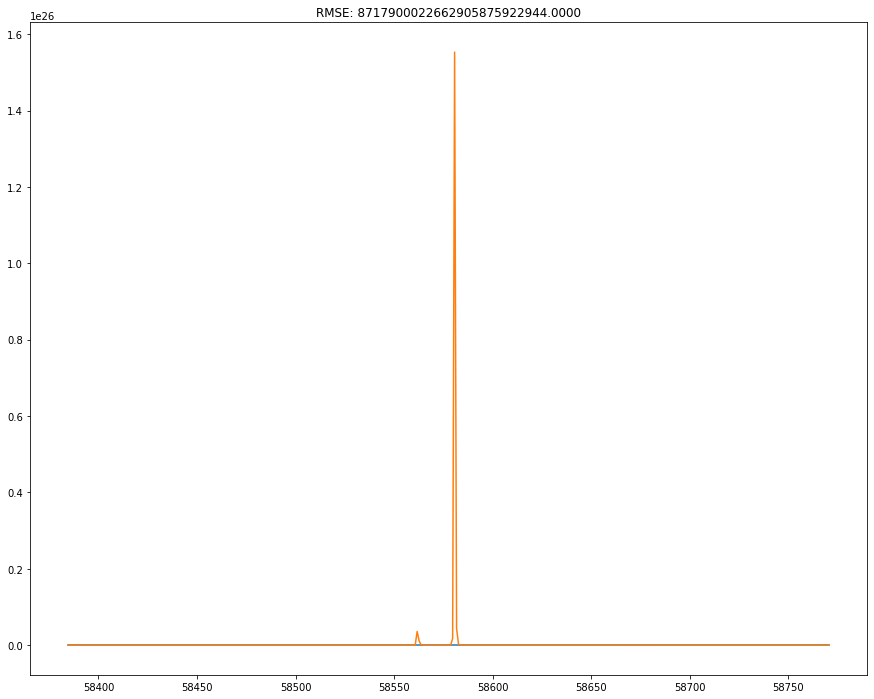

In [50]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

El modelo final quizás es sólo aproximado, pero el procedimiento ilustra cómo se calcula.